# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [6]:
using LsqFit
using GLM

In [7]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [8]:
using Glob
using CSV

In [9]:
using Statistics
using StatsBase
using Printf

In [10]:
using Logging

In [11]:
@quickactivate "JPetalo"

In [12]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [13]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [14]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [584]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [16]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [17]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

In [18]:
function grfq(q)
    return Float32(326.9 + 0.0226 * q)
end
rfq(q::Float32) = grfq(q)
rfq(q::Float64) = grfq(q)

rfq (generic function with 2 methods)

In [19]:
function grfq2(q)
    return Float32(297.85 + 0.031 * q)
end
rfq2(q::Float32) = grfq(q)
rfq2(q::Float64) = grfq(q)

rfq2 (generic function with 2 methods)

# Characterization of PETALO

In [366]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Debug, Dict{Any, Int64}())

### Read a summary data frame with photoelectric interactions

In [585]:
drx = datadir("nema3df")
input = string(drx,"/nemadf_f500_pde_1_sigmatof_1ps_kmeans_phot.csv")
n3df = DataFrame(CSV.File(input));

In [586]:
println(names(n3df))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r1q", "r1z", "r2", "r2q", "r2z", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xR1", "xR2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yR1", "yR2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zR1", "zR2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## Dependence of energy with radius of interaction
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution
- The reason is that the energy deposited in the SiPMs depends of the radius at which the gamms interacted.
- The relation is roughly linear in a good range of radius, cannot be used for charge too low and saturates for charge too high
- This dependence can be used to define an estimator, "rq" of the radius of interaction

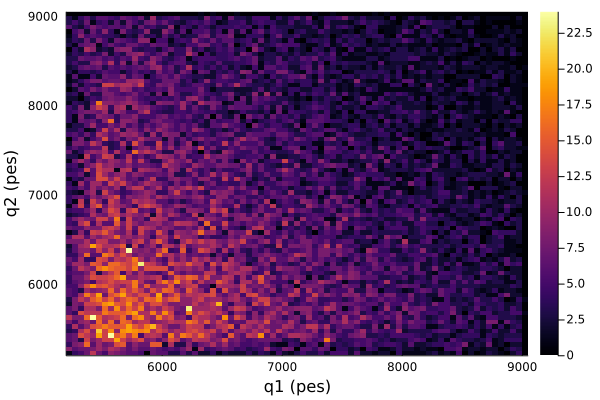

In [587]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.q2, 150, "q1 (pes)", "q2 (pes)", 5000., 10000., 5000., 10000.)
plot(phqr, legend=false, fmt = :png)

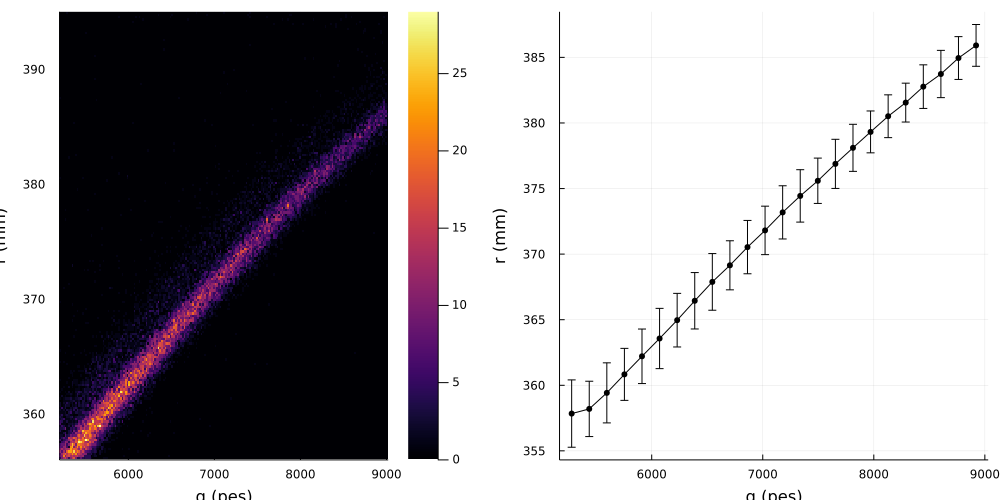

In [588]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.r1, 250, "q (pes)", "r (mm)")
pqrdf = JPetalo.p1df(n3df.q1, n3df.r1, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("q (pes)")
ylabel!("r (mm)")
plot(phqr, pp, legend=false, size = (1000, 500), fmt = :png)

### Below 5000 pes no reliable fit.

In [589]:
n3h1q0 = JPetalo.select_by_column_value_interval(n3df, "q1", 3000.0, 5200.0);

In [590]:
function fcqr(df; h=1, qmin=3000.0, qmax=5200.0, bin=5)
    function qr(h)
    if h==1
        return "q1", "r1"
    else
        return "q2", "r2"
    end
end
    qq, rr = qr(h)
    dfq   = JPetalo.select_by_column_value_interval(df, qq, qmin, qmax)
    pqrdf = JPetalo.p1df(dfq[!,qq], dfq[!,rr], bin)
    lfqr, pqr, cqr = JPetalo.lfit(pqrdf);
    return pqrdf, lfqr, pqr, cqr
end

fcqr (generic function with 5 methods)

## Fit in range (5200, 9000) 

### hemisphere 1

In [594]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=1, qmin=5200.0, qmax=9000.0, bin=25);

┌ Info: cqr
│   cqr = [315.07442310548026, 0.008028282147720892]
└ @ Main In[595]:1


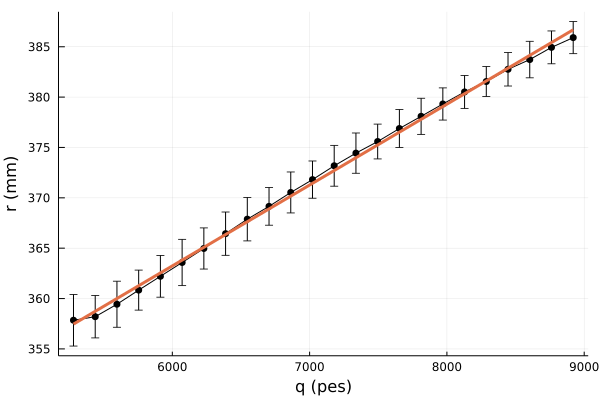

In [595]:
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

### hemisphere 2

┌ Info: cqr
│   cqr = [315.1505437812642, 0.008057495144259451]
└ @ Main In[596]:2


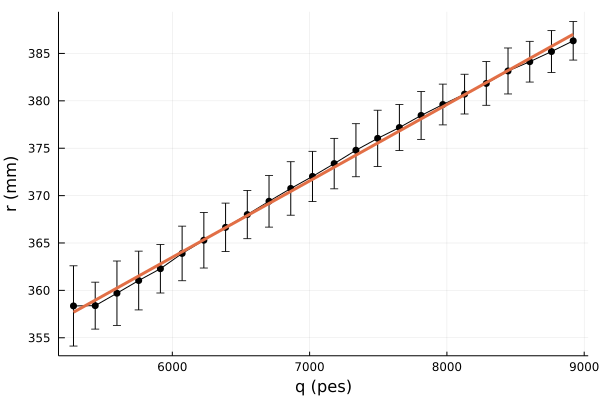

In [596]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=2, qmin=5200.0, qmax=9000.0, bin=25)
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

## Fit function

In [604]:
function rfq(q::Float64)
    return 315.1 + 0.008 * q
end

rfq (generic function with 8 methods)

### Fitted R as a function of q

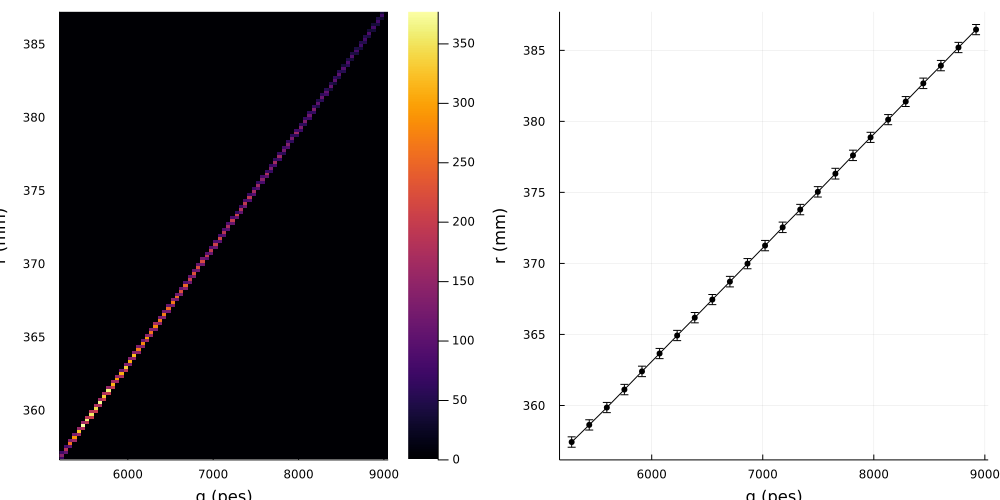

In [605]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,rfq.(n3df.q1), 150, "q (pes)", "r (mm)")
pqrdf = JPetalo.p1df(n3df.q1, rfq.(n3df.q1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("q (pes)")
ylabel!("r (mm)")
plot(phqr, pp, legend=false, size = (1000, 500), fmt = :png)

## Fitted R as a function of R

### Using all range

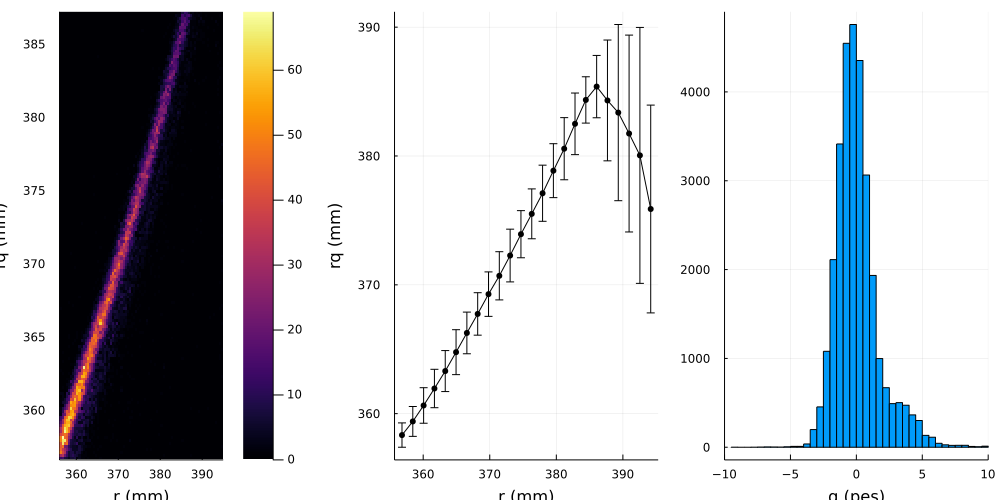

In [606]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.r1,rfq.(n3df.q1), 150, "r (mm)", "rq (mm)")
pqrdf = JPetalo.p1df(n3df.r1, rfq.(n3df.q1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("r (mm)")
ylabel!("rq (mm)")
hqc = JPetalo.hist1d(n3df.r1 - rfq.(n3df.q1), 50, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)");
plot(phqr, pp, phqc, layout = (1, 3), legend=false, size = (1000, 500), fmt = :png)

In [607]:
xmu, xstd = JPetalo.mean_std(n3df.r1 - rfqx.(n3df.q1), -4.0, 4.0)

(-0.022807969579914447, 1.3279488550067962)

### Cutting at 385.5 

In [608]:
n3h1q   = JPetalo.select_by_column_value_interval(n3df, "q1", 5200., 12000.)
n3h1qr   = JPetalo.select_by_column_value_interval(n3df, "r1", 355.5, 385.5);

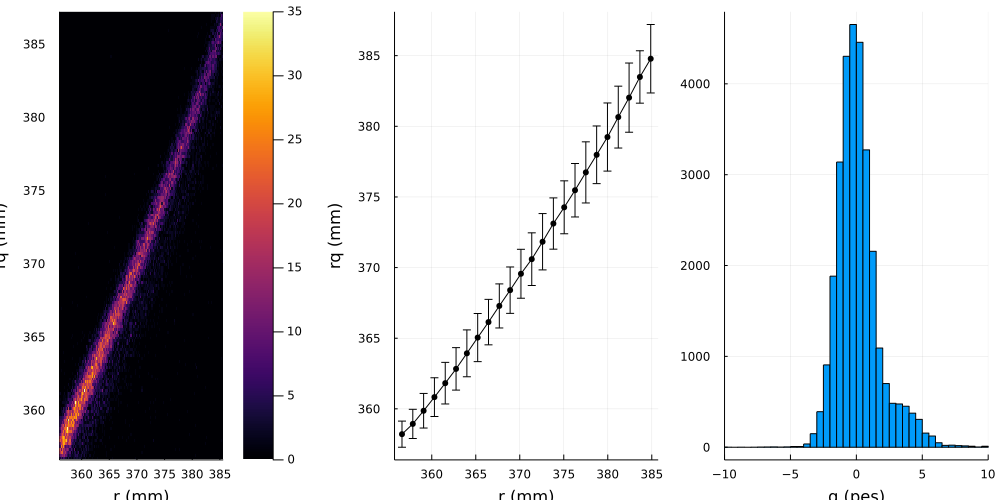

In [609]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3h1qr.r1,rfq.(n3h1qr.q1), 150, "r (mm)", "rq (mm)")
pqrdf = JPetalo.p1df(n3h1qr.r1, rfq.(n3h1qr.q1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("r (mm)")
ylabel!("rq (mm)")
hqc = JPetalo.hist1d(n3h1qr.r1 - rfqx.(n3h1qr.q1), 50, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)");
plot(phqr, pp, phqc, layout = (1, 3), legend=false, size = (1000, 500), fmt = :png)

In [616]:
xmu, xstd, mu, std, NN, xg, yg = JPetalo.fit_gauss(n3h1qr.r1 - rfqx.(n3h1qr.q1), -3.0, 3.0, 25)

(-0.13352839753635473, 1.1460458447640802, -0.1945707555953713, 1.1611110490250964, 4716.113172934683, [-2.75, -2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75], [418.58237461627135, 984.2597067800598, 1922.6708099016125, 3120.0863716220147, 4206.24686078982, 4710.742394750448, 4382.787467626365, 3387.489236117406, 2175.063266763643, 1160.1985577474834, 514.1137341407588, 189.2572597791459])

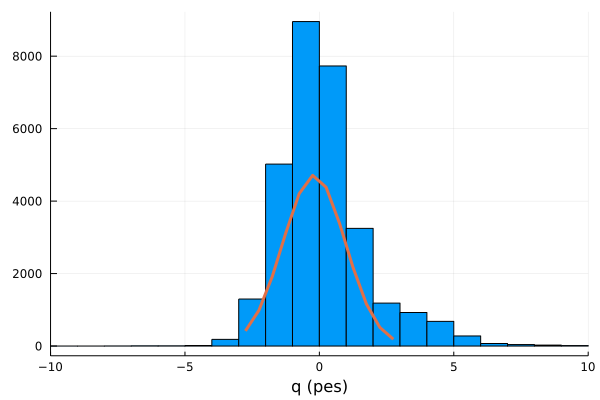

In [617]:
hqc = JPetalo.hist1d(n3h1qr.r1 - rfqx.(n3h1qr.q1), 25, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)", legend=false)
phqc = plot!(phqc, xg, yg, lw=3, xlimit=(-10.0,10.0), legend=false) 

### Number of SiPMs with charge above threshold

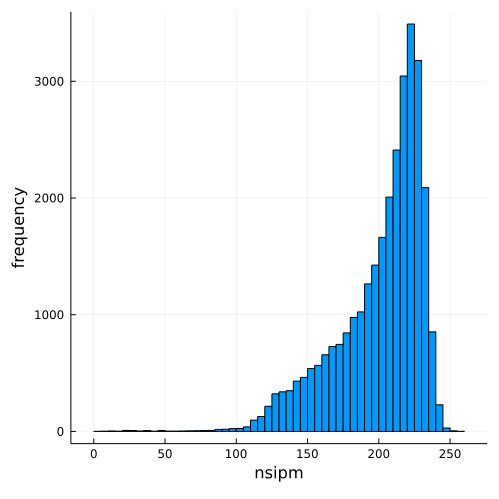

In [618]:
hnsipm, pnsipm = JPetalo.hist1d(n3df.nsipm1,  "nsipm", 50);
plot(pnsipm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

## zstd

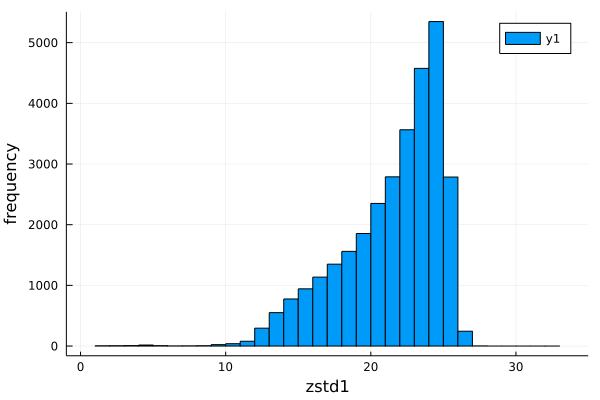

In [619]:
hzstd, pzstd = JPetalo.hist1d(n3df.zstd1, "zstd1", 50,  0., 35.)
plot(pzstd)

In [620]:
n3h1z = JPetalo.select_by_column_value_interval(n3df, "zstd1", 5.0, 25.0);

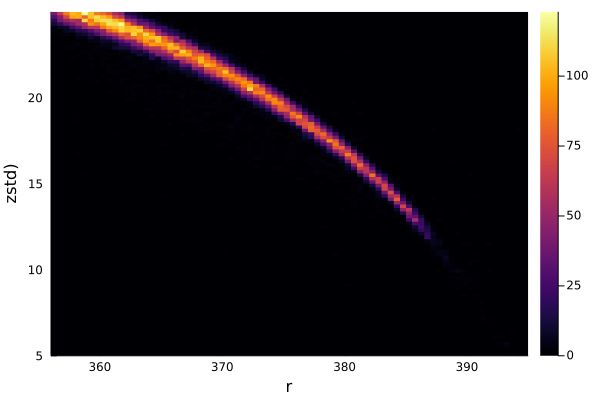

In [621]:
xe,ye,hrzstd,przstd = JPetalo.hist2d(n3h1z.r1, n3h1z.zstd1, 150, "r", "zstd)")
plot(przstd)

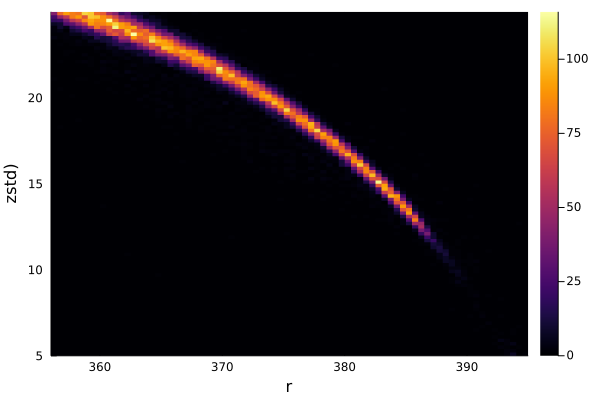

In [622]:
n3h2z = JPetalo.select_by_column_value_interval(n3df, "zstd2", 5.0, 25.0);
xe,ye,hrzstd,przstd = JPetalo.hist2d(n3h2z.r2, n3h2z.zstd2, 150, "r", "zstd)")
plot(przstd)

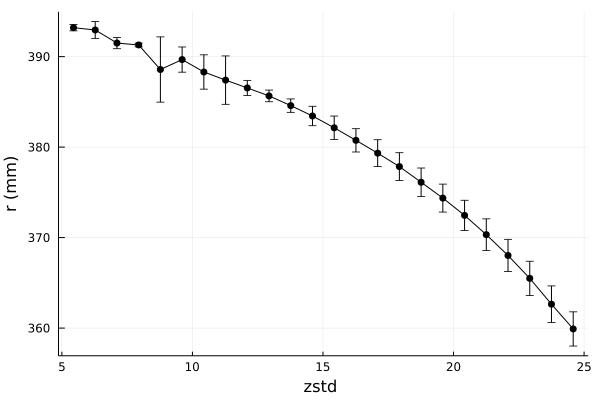

In [623]:
pqrdf = JPetalo.p1df(n3h1z.zstd1, n3h1z.r1 , 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("zstd ")
ylabel!("r (mm)")

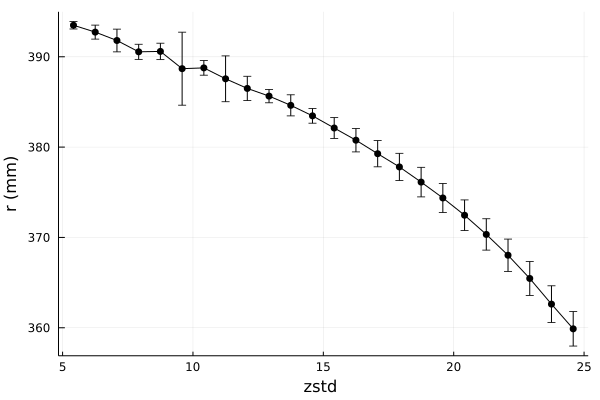

In [624]:
pqrdf2 = JPetalo.p1df(n3h2z.zstd2, n3h2z.r2 , 25)
pp2 = plot(pqrdf2.x_mean,pqrdf2.y_mean, yerror=pqrdf2.y_std, shape = :circle, color = :black, legend=false)
xlabel!("zstd ")
ylabel!("r (mm)")

In [643]:
function rfz(z)
    return 392.5 + 0.36 * z -0.065 * z^2
end

rfz (generic function with 1 method)

In [625]:
function fit_pol2(x,y)
    @. pol(x, p) = p[1] + p[2] * x + p[3] * x^2 
    p0 = [1.0, 1.0, 1.0]
    fq = curve_fit(pol, x, y, p0)
    cfq = coef(fq)
    @info "coef(fq)" cfq
    sfq = stderror(fq)
    @info "std(fq)" sfq
    @info "margin_of_error (90%)" margin_error(fq, 0.1)
    @info " confidence_interval (90%)" confidence_interval(fq, 0.1)
    return cfq
end


fit_pol2 (generic function with 1 method)

In [626]:
cfq = fit_pol2(pqrdf.x_mean, pqrdf.y_mean)

┌ Info: coef(fq)
│   cfq = [392.3135956352826, 0.3716706859399897, -0.06718130318547892]
└ @ Main In[625]:6
┌ Info: std(fq)
│   sfq = [0.9270945910361894, 0.1349758334478309, 0.00443059745487821]
└ @ Main In[625]:8
┌ Info: margin_of_error (90%)
│   margin_error(fq, 0.1) = [1.5952914377608034, 0.23225870745647312, 0.00762391912569805]
└ @ Main In[625]:9
┌ Info:  confidence_interval (90%)
│   confidence_interval(fq, 0.1) = [(390.7183041975218, 393.9088870730434), (0.13941197848351658, 0.6039293933964628), (-0.07480522231117698, -0.05955738405978087)]
└ @ Main In[625]:10


3-element Vector{Float64}:
 392.3135956352826
   0.3716706859399897
  -0.06718130318547892

In [627]:
cfq2 = fit_pol2(pqrdf2.x_mean, pqrdf2.y_mean)

┌ Info: coef(fq)
│   cfq = [392.627724238585, 0.3416908942628256, -0.06653424897272844]
└ @ Main In[625]:6
┌ Info: std(fq)
│   sfq = [0.7839022611184411, 0.11426845578766318, 0.0037540038658450767]
└ @ Main In[625]:8
┌ Info: margin_of_error (90%)
│   margin_error(fq, 0.1) = [1.348894252317741, 0.19662663431189426, 0.006459675509281269]
└ @ Main In[625]:9
┌ Info:  confidence_interval (90%)
│   confidence_interval(fq, 0.1) = [(391.2788299862673, 393.97661849090275), (0.14506425995093136, 0.5383175285747199), (-0.07299392448200971, -0.060074573463447176)]
└ @ Main In[625]:10


3-element Vector{Float64}:
 392.627724238585
   0.3416908942628256
  -0.06653424897272844

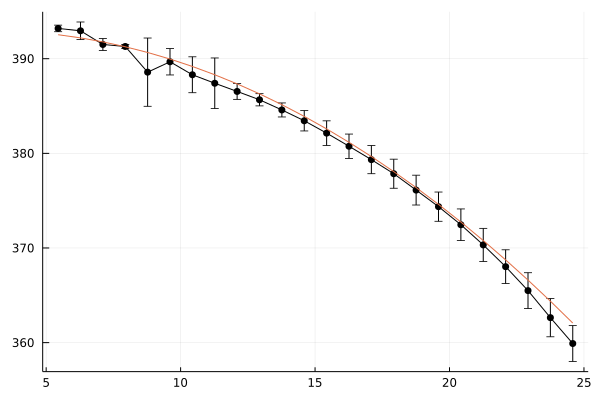

In [644]:
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pp = plot!(pp, pqrdf.x_mean, rfz.(pqrdf.x_mean))

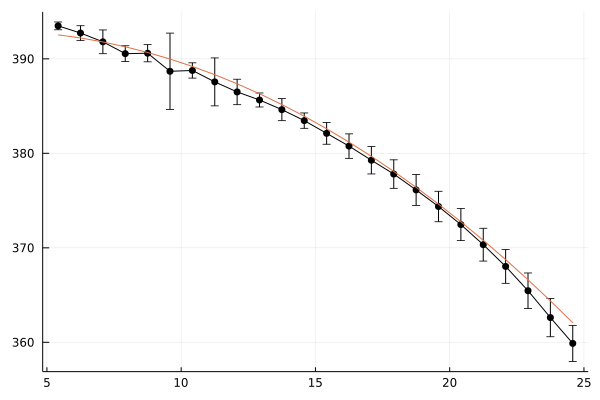

In [645]:
pp = plot(pqrdf2.x_mean,pqrdf2.y_mean, yerror=pqrdf2.y_std, shape = :circle, color = :black, legend=false)
pp = plot!(pp, pqrdf2.x_mean, rfz.(pqrdf2.x_mean))

## Fitted R from zstd as a function of R

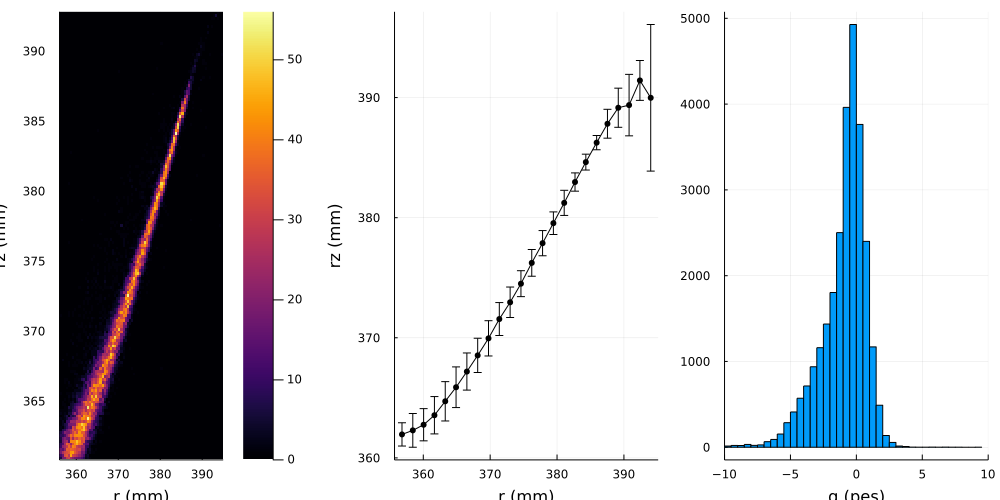

In [646]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3h1z.r1,rfz.(n3h1z.zstd1), 150, "r (mm)", "rz (mm)")
pqrdf = JPetalo.p1df(n3h1z.r1, rfz.(n3h1z.zstd1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("r (mm)")
ylabel!("rz (mm)")
hqc = JPetalo.hist1d(n3h1z.r1 - rfz.(n3h1z.zstd1), 50, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)");
plot(phqr, pp, phqc, layout = (1, 3), legend=false, size = (1000, 500), fmt = :png)

In [647]:
xmu, xstd = JPetalo.mean_std(n3h1z.r1 - rfzx.(n3h1z.zstd1), -2.0, 2.0)

(0.3643326683685488, 0.9525226001570731)

## Resolution in (x,y,z,r) intrinsic

In [650]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt1 - n3df.x1, "xt - xr", 50,  -5., 5.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [651]:
hytyr, pytyr = JPetalo.hist1d(n3df.yt1 - n3df.y1, "yt - yr", 50,  -5., 5.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [652]:
hztzr, pztzr = JPetalo.hist1d(n3df.zt1 - n3df.z1, "zt - zr", 50,  -5., 5.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

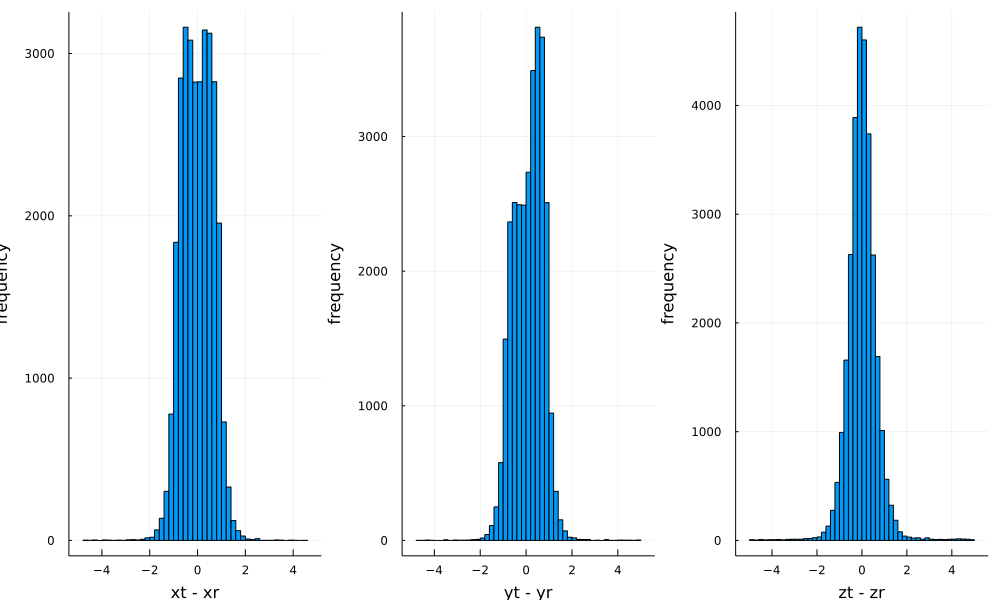

In [653]:
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [654]:
xmu, xstd = JPetalo.mean_std(n3df.xt1 - n3df.x1, -2.0, 2.0)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   0.6

In [655]:
xmu, xstd = JPetalo.mean_std(n3df.yt1 - n3df.y1, -2.0, 2.0)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   0.6

In [656]:
xmu, xstd = JPetalo.mean_std(n3df.zt1 - n3df.zr1, -2.0, 2.0)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   0.6

## Resolution in xyz (r from q)

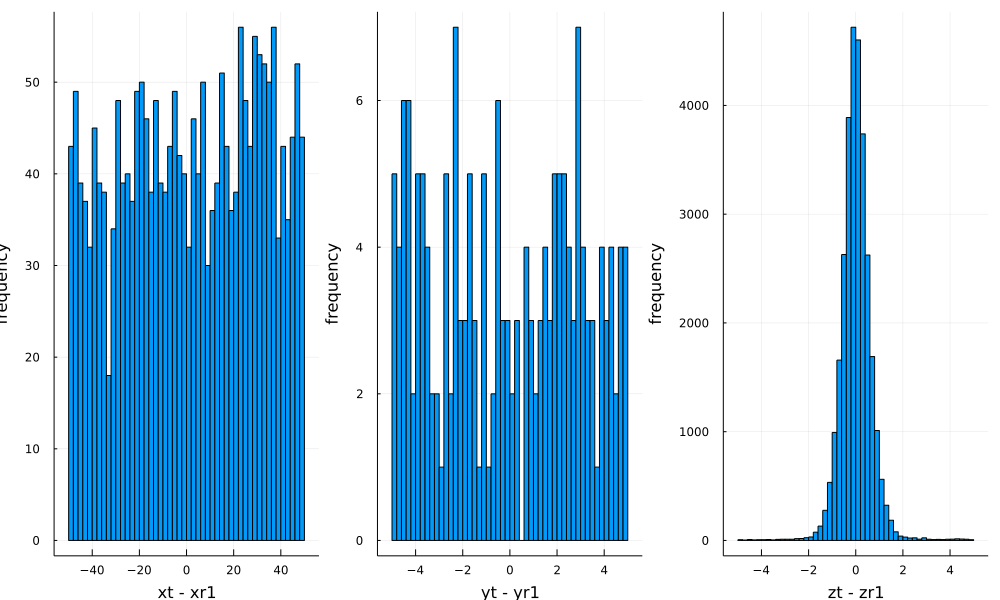

In [658]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt1 - n3df.xr1, "xt - xr1", 50,  -50., 50.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3df.yt1 - n3df.yr1, "yt - yr1", 50,  -5., 5.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3df.zt1 - n3df.zr1, "zt - zr1", 50,  -5., 5.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [659]:
@info names(n3df)

┌ Info: ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r1q", "r1z", "r2", "r2q", "r2z", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xR1", "xR2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yR1", "yR2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zR1", "zR2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]
└ @ Main In[659]:1


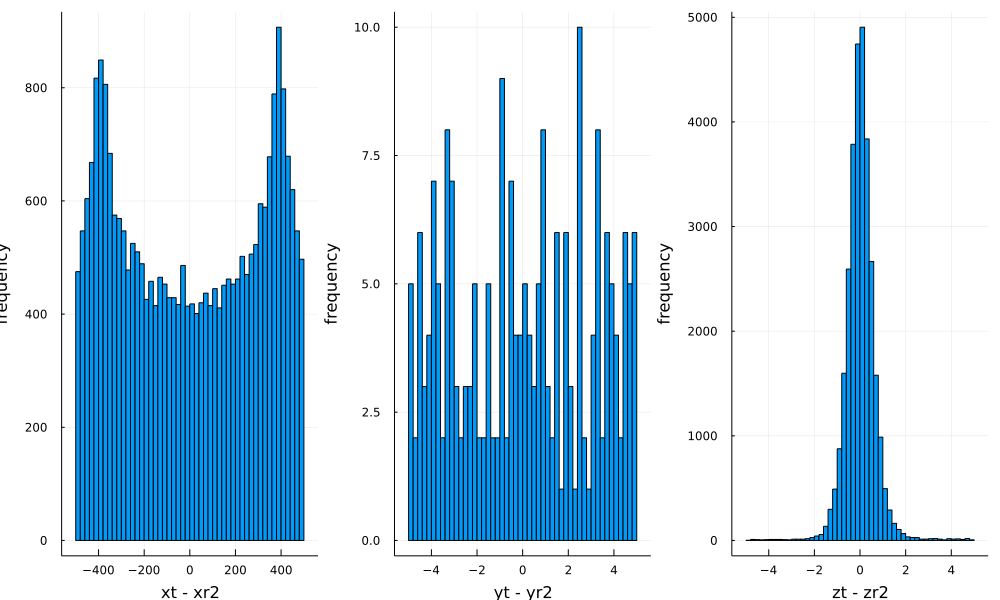

In [661]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt2 - n3df.xr2, "xt - xr2", 50,  -500., 500.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3df.yt2 - n3df.yr2, "yt - yr2", 50,  -5., 5.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3df.zt2 - n3df.zr2, "zt - zr2", 50,  -5., 5.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

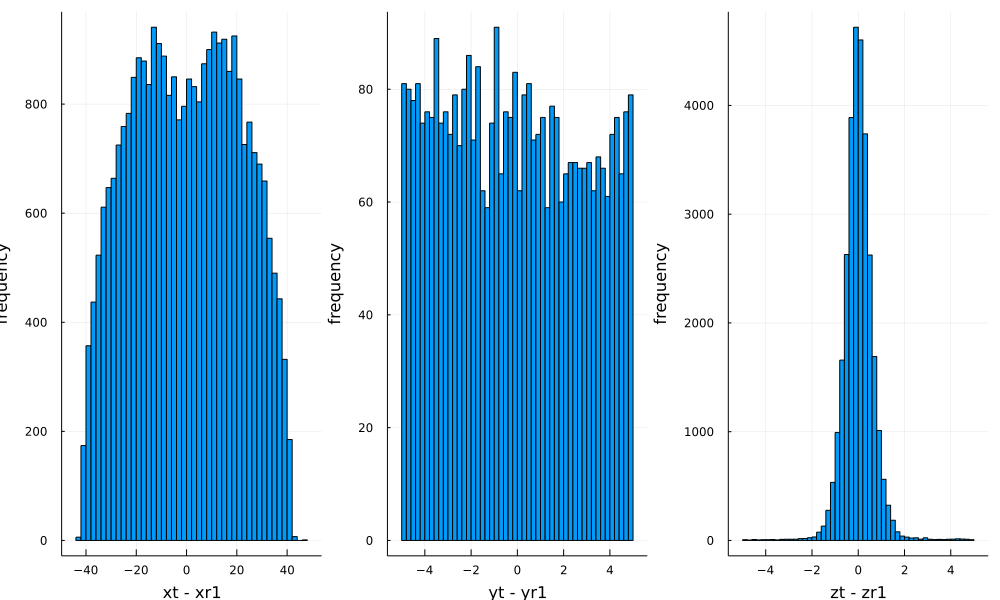

In [662]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt1 - n3df.xR1, "xt - xr1", 50,  -50., 50.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3df.yt1 - n3df.yR1, "yt - yr1", 50,  -5., 5.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3df.zt1 - n3df.zR1, "zt - zr1", 50,  -5., 5.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

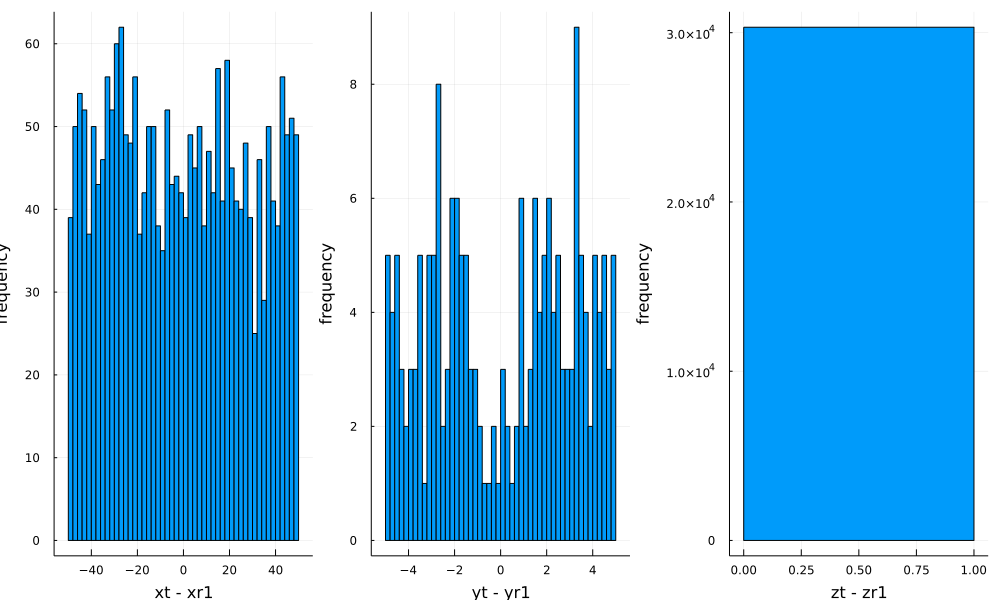

In [663]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xr1 - n3df.xR1, "xt - xr1", 50,  -50., 50.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3df.yr1 - n3df.yR1, "yt - yr1", 50,  -5., 5.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3df.zr1 - n3df.zR1, "zt - zr1", 50,  -5., 5.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [879]:
n3dfx = JPetalo.select_by_column_value(n3df, "xs", 0.0);

In [881]:
n3dfxy = JPetalo.select_by_column_value(n3dfx, "ys", 10.0);

In [883]:
n3dfxyz = JPetalo.select_by_column_value(n3dfxy, "zs", 0.0);

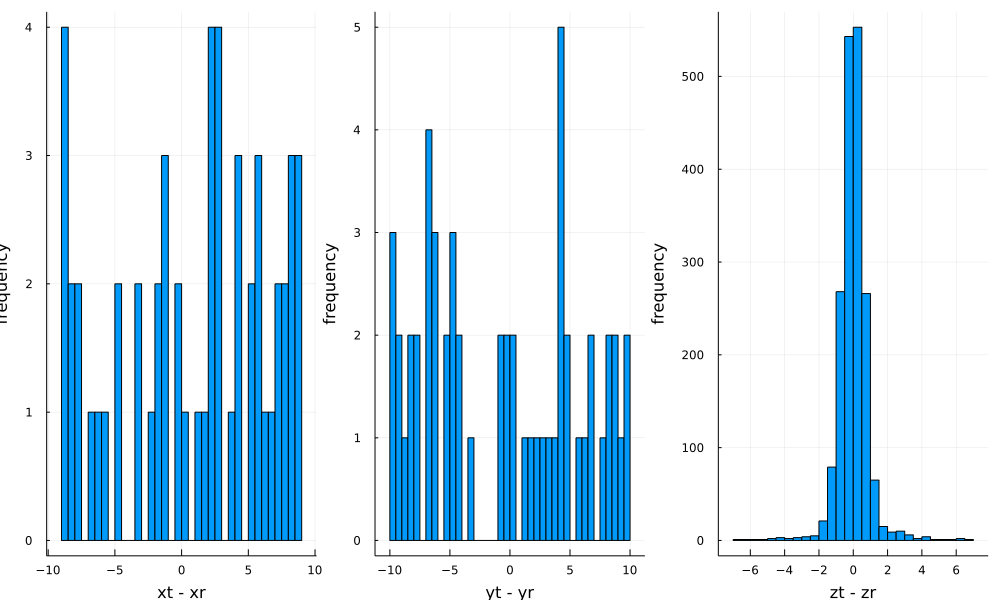

In [471]:
hx, px = JPetalo.hist1d(n3dfxyz.xt1 - n3dfxyz.xr1, "xt - xr", 50,  -10., 10.)
hy, py = JPetalo.hist1d(n3dfxyz.yt1 - n3dfxyz.yr1, "yt - yr", 50,  -10., 10.)
hz, pz = JPetalo.hist1d(n3dfxyz.zt1 - n3dfxyz.zr1, "zt - zr", 50,  -10., 10.)
plot(px, py, pz, layout = (1, 3), size = (1000, 600), legend=false, fmt = :png)

In [472]:
xmu, xstd = JPetalo.mean_std(n3dfxyz.xt1 - n3dfxyz.xr1, -5., 5.)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   2.8

## TOF

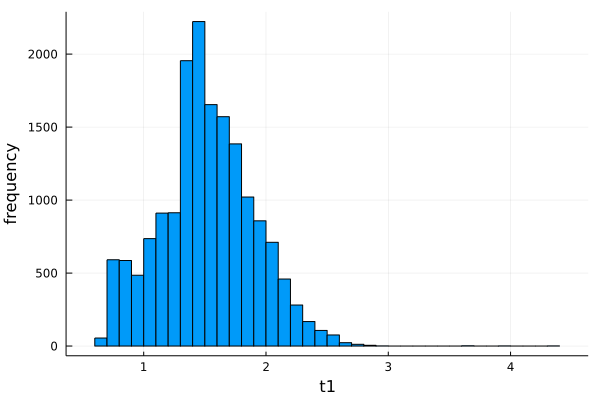

In [473]:
ht1, pt1 = JPetalo.hist1d(n3df.t1, "t1", 50,  -100., 100.)
plot(pt1, legend=false)

In [475]:
function ct12(df; reco=true)
    if reco
        return 1000.0*(df.tr1 - df.tr2)
    else
        return 1000.0 * (df.t1 - df.t2)
    end
end
        


ct12 (generic function with 1 method)

In [505]:
t12 = ct12(n3df, reco=false);

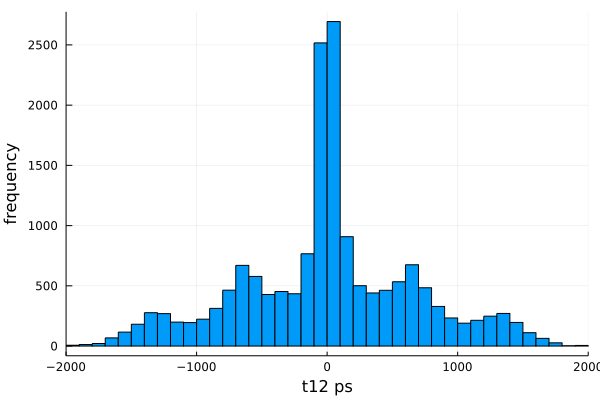

In [513]:
ht1t2, pt1t2 = JPetalo.hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(pt1t2, xlimit=(-2000.0,2000.0), legend=false)

In [504]:
xmu, xstd = JPetalo.mean_std(t12, -200.0, 200.0)

(0.8233535578489952, 70.47364950479162)

In [480]:
c0 =uconvert(mm/ns, float(SpeedOfLightInVacuum))

299.792458 mm ns⁻¹

In [481]:
cc = convert(Float32, c0/(mm*ns^-1))

299.79245f0

In [488]:
function ctsr(df; reco=true)
    if reco
        tsr1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        
    else
        tsr1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
    end
    return 1000.0*(tsr1 - tsr2)
end

ctsr (generic function with 1 method)

In [509]:
tsr12 = ctsr(n3df, reco=false);

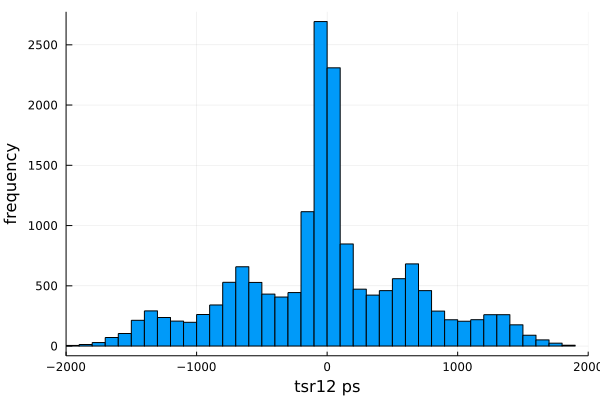

In [514]:
htsr12, psr1t2 = JPetalo.hist1d(tsr12, "tsr12 ps", 50,  -2000., 2000.)
plot(psr1t2, xlimit=(-2000.0,2000.0),legend=false) 

In [492]:
xmu, xstd = JPetalo.mean_std(tsr12, -200.0, 200.0)

(0.10099995709626054, 75.24133047684998)

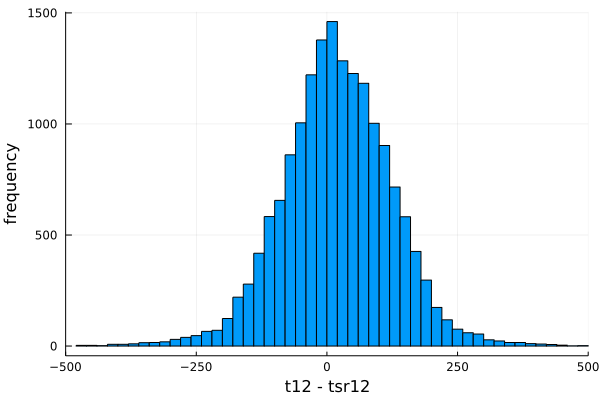

In [516]:
h12, p12 = JPetalo.hist1d(t12-tsr12, "t12 - tsr12", 50,  -500., 500.)
plot(p12, xlimit=(-500.0,500.0),legend=false) 

In [517]:
xmu, xstd = JPetalo.mean_std(t12-tsr12, -200.0, 200.0)

(16.140249616713525, 86.21127356217914)

In [535]:
function crb(df; reco=true)
    clxe = cc/1.6
    if reco
        trb1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
        
    else
        trb1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
     end
    return 1000.0*(trb1 - trb2)
end

crb (generic function with 1 method)

In [536]:
trb12 = crb(n3df, reco=false);

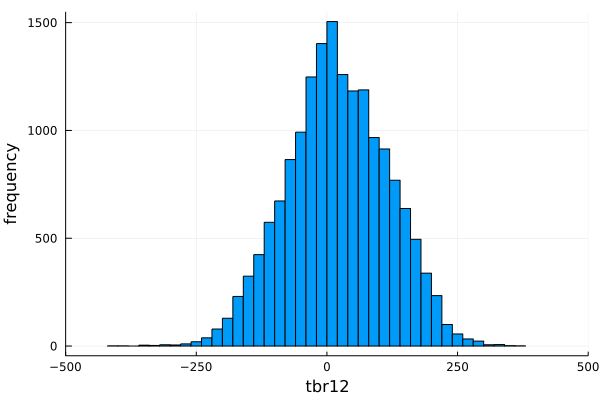

In [538]:
htrb12, ptrb12 = JPetalo.hist1d(trb12, "tbr12", 50,  -500., 500.)
plot(ptrb12, xlimit=(-500.0,500.0), legend=false) 

In [539]:
xmu, xstd = JPetalo.mean_std(trb12, -200.0, 200.0)

(17.035470529706238, 87.64974951575508)

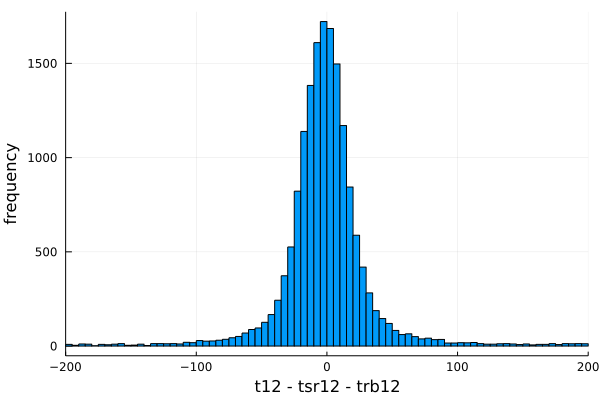

In [572]:
h12, p12 = JPetalo.hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 75,  -200., 200.)
p12 = plot(p12, xlimit=(-200.0,200.0), legend=false) 

In [545]:
xmu, xstd = JPetalo.mean_std(trb12, -50.0, 50.0)

(0.7007674651629061, 27.576667260855018)

In [575]:
function gfit_gauss(x, xmin, xmax, bins=50)
    function gausx(x, μ, σ, N)
        return N * exp(-(x - μ)^2/(2*σ^2))
    end
    
    xmu, xstd = JPetalo.mean_std(x, xmin, xmax)
    @debug xmu xstd
    
    h = JPetalo.hist1d(x,  bins, xmin, xmax)
    edges = collect(h.edges[1])
    w = h.weights
    c =[0.5 *(edges[i] + edges[i+1]) for i in 1:length(edges)-1]
    @debug "histo" edges w c 

    @. gauss1(x, p) = p[1]* exp(-(x - xmu)^2/(2*xstd^2))
    p0 = [1.0]
    fq = curve_fit(gauss1, c, w, p0)    
    NN =coef(fq)[1][1]
    @debug "gauss1" NN
     
    @. gauss3(x, p) = p[1]* exp(-(x - p[2])^2/(2*p[3]^2))
    p0 = [NN, xmu, xstd]
    fq = curve_fit(gauss3, c, w, p0)
    cfq = coef(fq)
    @debug "coef(fq)" cfq
    NN = cfq[1]
    mu =cfq[2]
    std  =cfq[3]
    @debug "gauss3" NN mu std
  
    return xmu, xstd, mu, std, NN, c, gausx.(c, (mu,), (std,), (NN),)    
end

gfit_gauss (generic function with 2 methods)

In [576]:
xmu, xstd, mu, std, NN, xg, yg = gfit_gauss(t12 - tsr12 - trb12, -100.0, 100.0, 50)

(-1.6892970924405932, 24.44586024974722, -1.9176580293233148, 17.51611947689116, 1691.2616767223615, [-97.5, -92.5, -87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5  …  52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5], [0.0005784133567832617, 0.0026364924096051977, 0.011077132442556287, 0.0428983691552597, 0.15313230749328638, 0.5038548951393932, 1.5281174973365652, 4.271895552060645, 11.007713398659426, 26.144853480300466  …  13.563456727078952, 5.3645947840535815, 1.9557623019204589, 0.6572155480295411, 0.20356926026639094, 0.058120478164669476, 0.015295327118575475, 0.0037102311848758248, 0.0008295752450439349, 0.00017097129744928397])

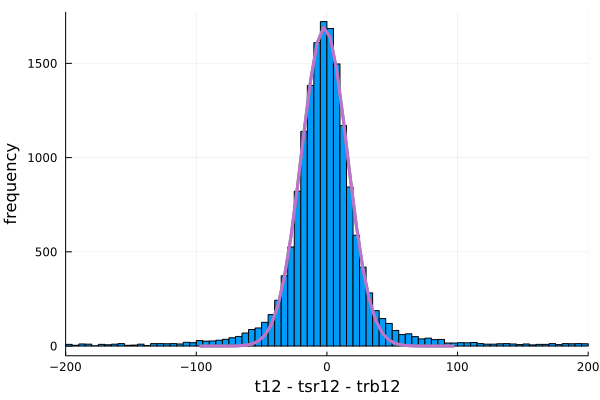

In [577]:
p12 = plot!(p12, xg, yg, lw=3, xlimit=(-200.0,200.0), legend=false) 

In [578]:
@info "TOF resolution = $std ps" 

┌ Info: TOF resolution = 17.51611947689116 ps
└ @ Main In[578]:1


In [582]:
xmu, xstd, mu, std, NN, xg, yg = JPetalo.fit_gauss(t12 - tsr12 - trb12, -100.0, 100.0, 50)

(-1.6892970924405932, 24.44586024974722, -1.9176580293233148, 17.51611947689116, 1691.2616767223615, [-97.5, -92.5, -87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5  …  52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5, 92.5, 97.5], [0.0005784133567832617, 0.0026364924096051977, 0.011077132442556287, 0.0428983691552597, 0.15313230749328638, 0.5038548951393932, 1.5281174973365652, 4.271895552060645, 11.007713398659426, 26.144853480300466  …  13.563456727078952, 5.3645947840535815, 1.9557623019204589, 0.6572155480295411, 0.20356926026639094, 0.058120478164669476, 0.015295327118575475, 0.0037102311848758248, 0.0008295752450439349, 0.00017097129744928397])

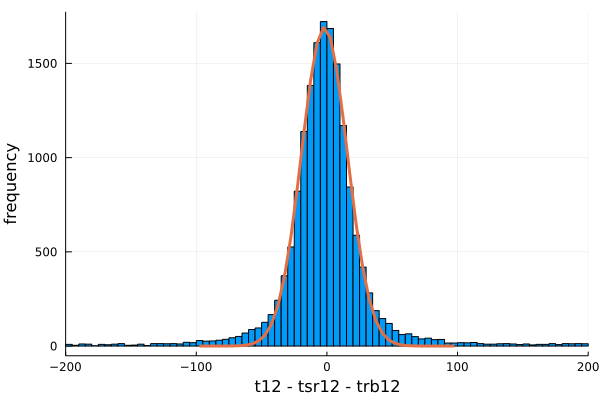

In [583]:
h12, p12 = JPetalo.hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 75,  -200., 200.)
p12 = plot(p12, xlimit=(-200.0,200.0), legend=false) 
p12 = plot!(p12, xg, yg, lw=3, xlimit=(-200.0,200.0), legend=false) 